In [29]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from itertools import product

import plotly as ply
from plotly.offline import init_notebook_mode
import plotly.figure_factory as ff
import plotly.graph_objs as go

init_notebook_mode(connected=True) 
np.set_printoptions(linewidth=160)

---

In [3]:
df_crimes = pd.read_csv("Crimes/table_4_crime_in_the_united_states_by_region_geographic_division_and_state_2014-2015_raw.csv")

In [4]:
df_ganja = pd.read_csv("marijuana-street-price-clean.csv")

---

In [5]:
df_crimes.head()

,Area,Year,Population2,Violent crime3,Unnamed: 4,Murder and nonnegligent manslaughter,Unnamed: 6,Rape (revised definition)4,Unnamed: 8,Rape (legacy definition)5,...,Property crime,Unnamed: 16,Burglary,Unnamed: 18,Larceny-theft,Unnamed: 20,Motor vehicle theft,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,NaN,NaN,NaN,,"Rate per \n100,000",,"Rate per \n100,000",,"Rate per \n100,000",,...,,"Rate per \n100,000",,"Rate per \n100,000",,"Rate per \n100,000",,"Rate per \n100,000",NaN,NaN
1,New England6,2014,14.689.812,42.550,"289,7",295,"2,0",4.559,"31,0",3.337,...,280.035,"1.906,3",53.116,"361,6",208.755,"1.421,1",18.164,"123,7",NaN,
2,NaN,2015,14.727.584,42.089,"285,8",321,"2,2",4.544,"30,9",3.464,...,256.342,"1.740,6",46.009,"312,4",192.654,"1.308,1",17.679,"120,0",NaN,NaN
3,NaN,Percent\nchange,,"-1,1","-1,3","+8,8","+8,5","-0,3","-0,6","+3,8",...,"-8,5","-8,7","-13,4","-13,6","-7,7","-7,9","-2,7","-2,9",NaN,NaN
4,Connecticut,2014,3.594.762,8.575,"238,5",89,"2,5",794,"22,1",579,...,69.326,"1.928,5",12.017,"334,3",51.195,"1.424,2",6.114,"170,1",NaN,NaN


In [6]:
df_ganja.head()

,State,HighQ,HighQN,MedQ,MedQN,LowQ,LowQN,date
0,Alabama,339.06,1042,198.64,933,149.49,123,2014-01-01
1,Alaska,288.75,252,260.60,297,388.58,26,2014-01-01
2,Arizona,303.31,1941,209.35,1625,189.45,222,2014-01-01
3,Arkansas,361.85,576,185.62,544,125.87,112,2014-01-01
4,California,248.78,12096,193.56,12812,192.92,778,2014-01-01


In [7]:
# CRIME DATASET PREPROCESSING
# Remove unused columns
del df_crimes['Unnamed: 23']
del df_crimes['Unnamed: 24']

In [8]:
# Remove percentage increase rows and unused rows
df_crimes = df_crimes.loc[df_crimes.index.map(lambda x : x%3 != 0 and x < 184)]

In [9]:
# Rename columns
_transl_table = str.maketrans({c:None for c in '0123456789,'})
_strip_junk = lambda x : x.translate(_transl_table).strip().replace('\n',' ').replace('  ',' ')
df_crimes.columns = np.array(list(map(_strip_junk, df_crimes.columns.values )))

l = []
for i,val in enumerate(df_crimes.columns):
    if val == 'Unnamed:':
        l.append(val_prev + ', rate per 100,000')
    else:
        l.append(val)
        val_prev = val
df_crimes.columns = l
del l,i,val,val_prev

In [10]:
# Rename states, replicate names where missing
df_crimes.Area[0::2] = df_crimes.Area[0::2].map(_strip_junk)
df_crimes.Area[1::2] = df_crimes.Area[0::2]

In [11]:
df_crimes.sort_values(by=['Area', 'Year'], inplace=True)

In [12]:
df_crimes.index = range(1, 1+len(df_crimes.index))

In [13]:
df_crimes.head()

,Area,Year,Population,Violent crime,"Violent crime, rate per 100,000",Murder and nonnegligent manslaughter,"Murder and nonnegligent manslaughter, rate per 100,000",Rape (revised definition),"Rape (revised definition), rate per 100,000",Rape (legacy definition),...,Aggravated assault,"Aggravated assault, rate per 100,000",Property crime,"Property crime, rate per 100,000",Burglary,"Burglary, rate per 100,000",Larceny-theft,"Larceny-theft, rate per 100,000",Motor vehicle theft,"Motor vehicle theft, rate per 100,000"
1,Alabama,2014,4.846.411,20.727,"427,7",276,"5,7",2.005,"41,4",1.425,...,13.744,"283,6",154.087,"3.179,4",39.723,"819,6",104.223,"2.150,5",10.141,"209,2"
2,Alabama,2015,4.858.979,22.952,"472,4",348,"7,2",2.039,"42,0",1.456,...,15.954,"328,3",144.746,"2.978,9",35.255,"725,6",99.156,"2.040,7",10.335,"212,7"
3,Alaska,2014,737.046,4.684,"635,5",41,"5,6",771,"104,6",553,...,3.243,"440,0",20.334,"2.758,9",3.150,"427,4",15.445,"2.095,5",1.739,"235,9"
4,Alaska,2015,738.432,5.392,"730,2",59,"8,0",901,"122,0",650,...,3.671,"497,1",20.806,"2.817,6",3.511,"475,5",15.249,"2.065,1",2.046,"277,1"
5,Arizona,2014,6.728.783,26.422,"392,7",311,"4,6",3.272,"48,6",2.356,...,16.614,"246,9",213.406,"3.171,5",43.412,"645,2",152.683,"2.269,1",17.311,"257,3"


In [14]:
s1 = set(df_crimes['Area'][::2])
s2 = set(df_ganja['State'])

/print s1-s2
print("="*120)
/print s2-s1

{'South Atlantic', 'West North Central', 'East North Central', 'West South Central', 'Puerto Rico', 'Middle Atlantic', 'Mountain', 'East South Central', 'Pacific', 'New England'}
set()


In [15]:
df_crimes.to_csv("Crimes/table_4_crime_in_the_united_states_by_region_geographic_division_and_state_2014-2015.csv")

In [16]:
df_ganja.columns.values

array(['State', 'HighQ', 'HighQN', 'MedQ', 'MedQN', 'LowQ', 'LowQN', 'date'], dtype=object)

In [17]:
df_ganja['Amount'] = df_ganja.HighQ * df_ganja.HighQN + df_ganja.MedQ * df_ganja.MedQN

In [18]:
df_joined = df_crimes[['Area', 'Population', 'Violent crime']][df_crimes.Year == '2014'].merge(
    df_ganja[['State', 'Amount']].groupby('State').sum(),
    left_on = 'Area', right_on = 'State'
#     pd.DataFrame.merge()
)

In [19]:
df_joined.head()

,Area,Population,Violent crime,Amount
0,Alabama,4.846.411,20.727,3.271121e+08
1,Alaska,737.046,4.684,9.021175e+07
2,Arizona,6.728.783,26.422,5.236423e+08
3,Arkansas,2.966.835,14.248,1.796538e+08
4,California,38.792.291,153.763,3.084078e+09


---

In [48]:
dt.strptime(df_ganja.date.iloc[0], '%Y-%m-%d').date()

datetime.date(2014, 1, 1)

In [40]:
df_ganja.sort_values('date')[df_ganja.State == 'Arizona']      \
.head()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,State,HighQ,HighQN,MedQ,MedQN,LowQ,LowQN,date,Amount
20096,Arizona,303.52,1934,209.19,1619,189.45,222,2013-12-27,925686.29
20861,Arizona,303.52,1934,209.19,1619,189.45,222,2013-12-28,925686.29
21575,Arizona,303.46,1937,209.30,1622,189.45,222,2013-12-29,927286.62
22289,Arizona,303.46,1937,209.43,1623,189.45,222,2013-12-30,927706.91
22799,Arizona,303.33,1939,209.35,1624,189.45,222,2013-12-31,928141.27


In [34]:
df_legal = pd.read_csv('legal.csv')

In [37]:
df_legal.head()

,year,state,law
0,2010,California,Decriminalized
1,2011,Delaware,Medicinal
2,2011,Connecticut,Decriminalized
3,2012,Connecticut,Medicinal
4,2012,Rhode Island,Decriminalized


In [144]:
df_legal = df_legal[df_legal.year.isin(['2014', 'mid-2014', '2015'])]
df_legal = df_legal[df_legal.state.isin(states)]
df_legal.index(index = range(len(df_legal))

In [111]:
states = ['California', 'Florida', 'New York', 'Utah', 'Alabama', 'Maryland', 'Alaska', 'Oregon', 'Missouri',
          'Minnesota', 'Mississippi', 'Iowa', 'Louisiana', 'North Carolina', 'South Carolina']

In [122]:
limits = {qual+'_'+lim: limfunc(df_ganja[qual]) for qual,(lim,limfunc) in product(['HighQ', 'MedQ'], ( ('Min',min),('Max',max) ))}

In [139]:
rows = 3; cols = 5
fig = ply.tools.make_subplots(rows, cols , subplot_titles = states)

for st,(row,col) in zip(df_legal.state, product(range(rows),range(cols))):
    _part = df_ganja[df_ganja.State == st].sort_values('date')
    fig.append_trace(go.Scatter(
        x = _part.date.apply(lambda x : dt.strptime(x, '%Y-%m-%d').date()),
        y = _part.HighQ,
        marker = {'color': 'blue'}
    ), row = row+1, col = col+1 )
#     fig.append_trace(go.Scatter(
#         x = _part.date.apply(lambda x : dt.strptime(x, '%Y-%m-%d').date()),
#         y = _part.MedQ,
#         marker = {'color': 'green'}
#     ), row = row+1, col = col+1 )

fig['layout']['showlegend'] = False
# for k in fig['layout']:
#     if k[:5] == 'yaxis': fig['layout'][k]['range'] = [limits['HighQ_Min'], limits['HighQ_Max']]
# fig['layout']['shapes'] = [ {
#     'type': 'line',
    
# } ]

This is the format of your plot grid:
[ (1,1) x1,y1 ]    [ (1,2) x2,y2 ]    [ (1,3) x3,y3 ]    [ (1,4) x4,y4 ]    [ (1,5) x5,y5 ]  
[ (2,1) x6,y6 ]    [ (2,2) x7,y7 ]    [ (2,3) x8,y8 ]    [ (2,4) x9,y9 ]    [ (2,5) x10,y10 ]
[ (3,1) x11,y11 ]  [ (3,2) x12,y12 ]  [ (3,3) x13,y13 ]  [ (3,4) x14,y14 ]  [ (3,5) x15,y15 ]



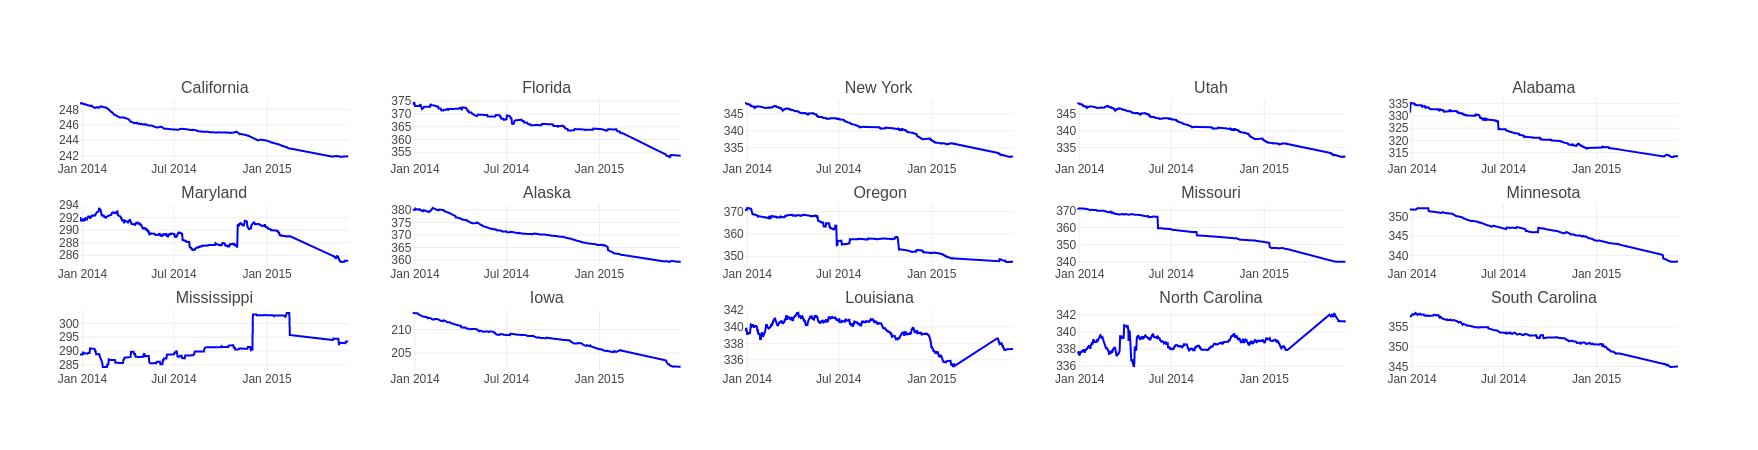

In [140]:
ply.offline.iplot(fig, validate=False)

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>